In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Correlation Among Key Lab Values

## Data Sources:
- **LABEVENTS.csv** for lab measurement results and timestamps.
- **D_LABITEMS.csv** to translate item IDs into readable lab test names.

## Visualization:
- Pairwise **Scatterplots** / **Correlation Matrix** among common labs (e.g., **WBC count, hemoglobin, creatinine, glucose, sodium**) for a subset of patients (e.g., first ICU stay).

## Why It’s Interesting:
- Labs are crucial in ICU decision-making; understanding how they interrelate can highlight patterns (e.g., _does high creatinine usually accompany elevated potassium?_).
- **Stratifying by outcome** can reveal prognostic patterns.


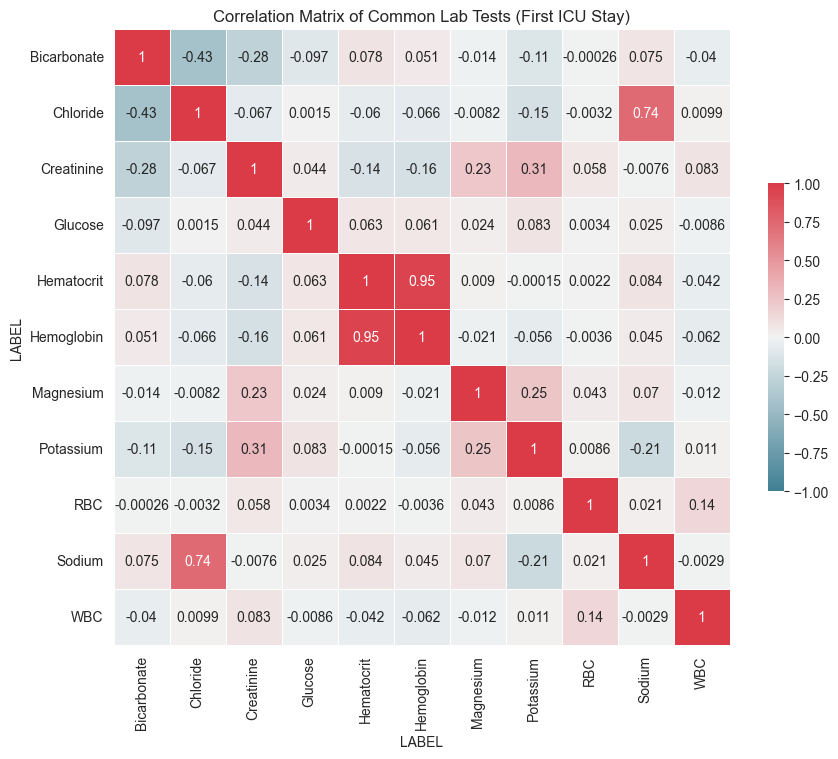

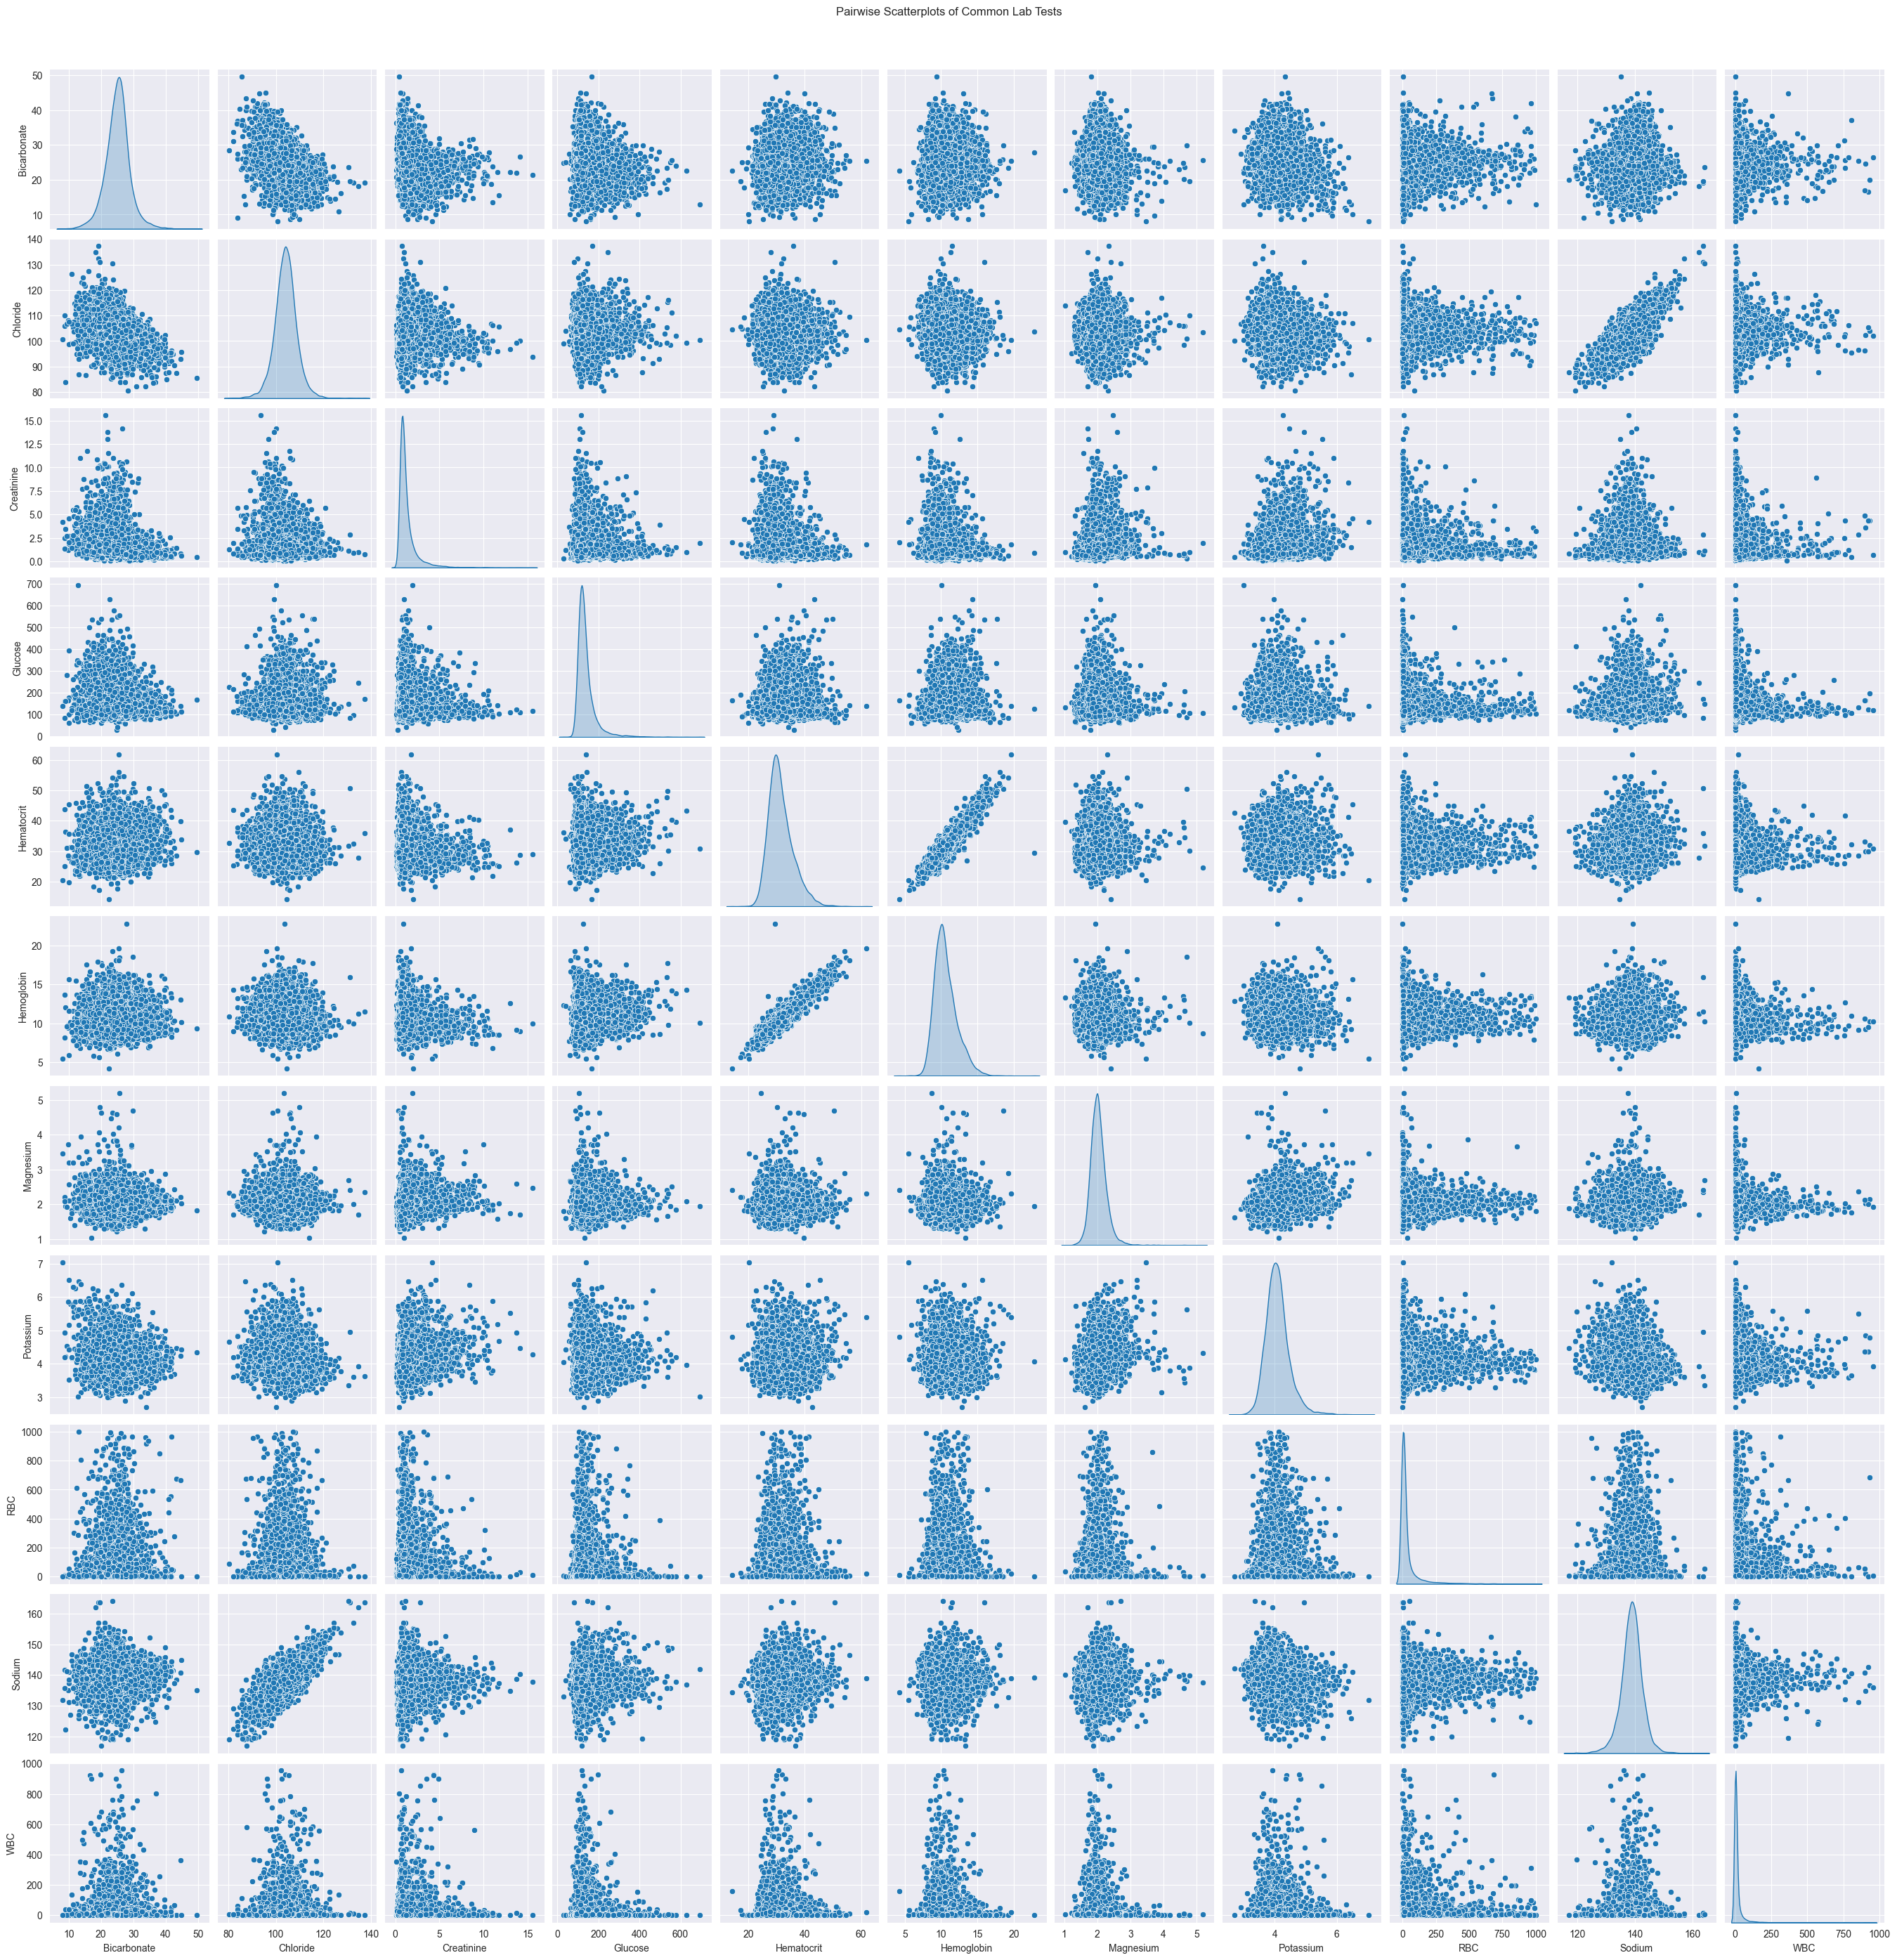

In [5]:
labevents = pd.read_csv("data/LABEVENTS.csv", parse_dates=['CHARTTIME'], low_memory=False)
d_labitems = pd.read_csv("data/D_LABITEMS.csv", low_memory=False)

# Merge to get readable lab test names
labevents = labevents.merge(d_labitems[['ITEMID', 'LABEL']], on='ITEMID', how='left')

# Sort and select first hospital admission per patient
labevents = labevents.sort_values(['SUBJECT_ID', 'CHARTTIME'])
first_admissions = labevents.groupby('SUBJECT_ID')['HADM_ID'].first().reset_index()
labevents_first = labevents.merge(first_admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Define common labs
common_labs = [
    'RBC', 'Hemoglobin', 'Hematocrit', 'WBC', 'Platelets', 'Sodium', 'Potassium', 'Chloride', 'Bicarbonate',
    'Creatinine', 'BUN', 'ALT', 'AST', 'Total Bilirubin', 'Glucose', 'Calcium', 'Magnesium', 'Phosphorus'
]

# Filter for common labs
labevents_common = labevents_first[labevents_first['LABEL'].isin(common_labs)]

# Pivot to wide format
lab_pivot = labevents_common.pivot_table(
    index='SUBJECT_ID',
    columns='LABEL',
    values='VALUENUM',
    aggfunc='mean'
).dropna()

# Compute correlation matrix
correlation_matrix = lab_pivot.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Common Lab Tests (First ICU Stay)')
plt.show()

# Plot pairwise scatterplots
sns.pairplot(lab_pivot, diag_kind='kde')
plt.suptitle('Pairwise Scatterplots of Common Lab Tests', y=1.02)
plt.show()